# Assessed Exercise for Deep Learning (M)

This exercise must be submitted as a colab notebook. Deadline  Monday the 4th of March, 15:00.





You will create a classifier and test it on a collection of images for a new task. While you are welcome to build a full network from scratch, most of you will not have sufficient access to the data and compuational power required, so you are welcome to provide a solution based on transfer learning from a pre-trained network, adapted to your new task. 

The Keras documentation has some examples of pretrained networks which are easy to integrate, see for example  their ResNet50 example [https://keras.io/applications/#classify-imagenet-classes-with-resnet50](https://keras.io/applications/#classify-imagenet-classes-with-resnet50), or the InceptionV3 network  [https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes](https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes). If you use the pretrained model, a good way to start is by freezing all layers up to the last layer before the output. Adapt the output layer to fit your classification problem. You might then unfreeze some earlier layers for further fine tuning.

You will need to create a training set (at least 100 images per class, potentially classifying e.g type of location, activity. If you are training a full network from scratch you would need orders of magnitude more, but this will work for transfer learning on an existing network). It might be sensible to start off testing and demonstrating your approach by using an existing dataset e.g. 
the [flowers one](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/). You can find other interesting datasets at:
*   [http://deeplearning.net/datasets](http://deeplearning.net/datasets/)  
*   [UCI ML collection](https://archive.ics.uci.edu/ml/datasets.html)
*   [https://www.visualdata.io](https://www.visualdata.io)
*   [https://ai.google/tools/datasets](https://ai.google/tools/datasets/ )

Students who put more effort into creating and analysing an interesting dataset will tend to do better in marks for sections 1. & 2. below.

Write a pre-processing step that will resize and crop the images to the right size ((224, 224) is default for ResNet50 and (299,299) is the default for Inception), and consider how you can apply data augmentation techniques to your new dataset, and design appropriate pre-processing functions.

In your submission you should have the following structure (share of the AX marks given in brackets at the end of each part):

1.   Analysis of the problem. (15%)
2.   Visualisation and analysis of the data type, quality and  class distributions. You may want to design some data augmentation in your system. (20%)
3.   Creation of multiple candidate network architectures. Include your justification of the design decisions. You should inlcude one very simple baseline model (e.g. a linear model, or a simple two layer Densely connected model). (15%)
4.   Training. This should include code for hyperparameter search, regularisation methods. (15%)
5.   Empirical evaluation of performance, and potentially visualisation and  analysis of the trained network. This should make good use of graphs and tables of results, confusion matrices etc to represent the relative performance of the different models.  Explain why you chose the metrics you use. (20%)
6.   Report on the performance, discussing the suitability of the final network for use. (15%)

For each of the design decisions, make sure you describe in detail the motivation behind them. 

**Submission process**

You should submit the colab notebook with *all* code needed to run your model and all visualisations of results in place (I don't want to have to run 80 projects :-) ). This exercise must be submitted as a colab notebook. Deadline Monday the 4th of March, 15:00. If you have your own training data, make sure that any links to that are accessible by 3rd parties (me - I won't share the links with anyone else).

Share the Colab link (click on Share on top right of the Colab notebook, then 'Get shareable link') with me by e-mail [Roderick.Murray-Smith@glasgow.ac.uk](mailto:Roderick.Murray-Smith@glasgow.ac.uk?subject=Deep Learning AX 2019) and make sure that the Subject of the e-mail is *exactly* `'Deep Learning AX 2019'` (automatically generated if you click on the e-mail hyperlink above)

# Some code snippets which might be useful to get you started

In [1]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

Using TensorFlow backend.


# Additional Notebook Setup

## Google Drive Mounting

The following cell mounts the Google Drive where data is stored and sets the 'BASE_PATH' variable which points to this project.

In [2]:
path = os.getcwd()
BASE_PATH = "" # set manually if not using CoLab
print(path)
if path == '/content' or path == '/content/gdrive/My Drive/building_classifier':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/building_classifier/'
    os.chdir('/content/gdrive/My Drive/building_classifier/')
    
else:
    print("Please set BASE_PATH manually")

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports

In [3]:
# Image Processing
import glob
import cv2
from skimage.transform import resize

# Deep copying
from copy import deepcopy

# For custom DataGenerator
from keras.utils import Sequence, to_categorical

# For making sequantial models
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D

#VGG16
from keras.applications.vgg16 import VGG16

# Hyperparameter search
# installing from github to get latest version which includes CheckPointSaver
! pip install git+https://github.com/scikit-optimize/scikit-optimize/ 
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt import dump, load
from skopt.plots import plot_objective, plot_evaluations

# used to count number of cpus for multiprocessing with DataGenerators 
import multiprocessing

# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# saving results
import pickle

  Cloning https://github.com/scikit-optimize/scikit-optimize/ to /tmp/pip-req-build-of88h_yt
  Stored in directory: /tmp/pip-ephem-wheel-cache-hb2lzjcr/wheels/66/66/b5/e1160753c1f4d7763be2755539df2c2ebd6e50f987dbea6abf
Successfully built scikit-optimize


# Analysis of the Problem

The aim of this project is to develop a classifier to identify buildings from the University of Glasgow. Such a model could then be embedded into a smartphone app to help navigation for new students at the University.

The main issue with the task is achieving a large enough dataset with enough variance to sufficently train the model and allow it to generalize generalize well. 

To be applicable for deployment the model must be able to identify a building from any point around it. Furthermore the model should work in varying weather conditions.

It would not be practical to collect data for every building on campus and so this model has been limited to six buildings. This will serve as a proof of concept whilst keeping the time to collect the dataset feasible.

# Creating the Dataset

For the dataset, six buildings were chosen:


*   Boyd Orr
*   Adam Smith
*   Rankine
*   James Watt (South)
*   Main Building
*   Reading Room

These particular buildings were chosen as it provides a good mix of completely different archtectures along with very similiar designs. For example, both the Adam Smith and Rankine building have a very similiar exterior.

To generate the large amount of data needed to train the models, videos were taken of the buildings and the idividual frames extracted. This does cause an issue as consecutive recorded frames are very similiar. When chosing test sets it was ensured that this effect was kept to a minimum.

As the model is expected to work from any point around a building, when collecting the videos they were recorded from around the full building however due to limitations such as construction work/other buildings this was not always possible.

To try and allow the model to handle various weather conditions full recordings of all six buildings were conducted on four different days.

The following table provides a description of the weather for each day:

Day     | Weather 
---|---
12/02/2019   | Cloudy      
14/02/2019   | Cloudy
15/02/2019  | Sunny
17/02/2019 | Cloudy w/ Sunny Intervals

It should be noted that the time of recording was very similair and as a result, no evening videos were recorded. To address this, data augmentation is introduced later on. Furthermore, the weather variation is limited. For example, there are no videos of rain, snow or fog.

The videos were recorded at 720p using a mobile phone with no wide angle lense.


## Image Processing
The following code extracts the individual frames from the videos, crops them to a 720x720 then resizes them to 224x224.

Videos are stored in the format: *raw/'date_taken'/'building_name_number'.mp4*. For example: *"raw/12_02_2019/adam_1.mp4"*

The extracted frames are stored in the format: *processed/'date_taken'/'building_name'/'number'.png*. For example: *processed/12_02_2019/adam/1.png*

It was noticed later that the colours of the images had been distorted during the processing. As the details of the images were unaltered this issue was not addressed and the images were not re-generated.

In [0]:
TARGET_IMAGE_SHAPE = (224, 224)
TARGET_IMAGE_FORMAT = '.png'
PROCESS_VIDEOS = False # set to false to prevent accidental overwriting

In [0]:
video_folders = ["12_02_2019", "14_02_2019", "15_02_2019", "17_02_2019"]

labels = ["rankine", "james", "main", "reading", "boyd", "adam"]

In [0]:
def make_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [0]:
PROCESSED_PATH = BASE_PATH + 'data/processed/'
make_path(PROCESSED_PATH)

In [0]:
# assumes landscape ratio (crops images to 720x720)
def crop_to_square(image):
    height = image.shape[0]
    width_centre = image.shape[1]/2
    start_width = int(width_centre - (height/2))
    end_width = int(width_centre + (height/2))
    return image[:,start_width:end_width,:]

In [0]:
if PROCESS_VIDEOS:
    for folder in video_folders:
        print("Processing Folder:", folder)

        VIDEO_PATH = BASE_PATH + 'data/raw/' + folder
        processed_folder_path = PROCESSED_PATH + folder + "/"
        make_path(processed_folder_path)

        count = 0 # variable used to give images different names 
        for path in glob.glob(VIDEO_PATH + "/*.mp4"):
            split_path = path.split("/")
            file_name = split_path[-1]
            split_file_name = file_name.split('_')
            building = split_file_name[0] 
            image_folder_path = processed_folder_path + building + '/'
            make_path(image_folder_path)

            vidcap = cv2.VideoCapture(path)
            success = 1
            while success:
                success, img = vidcap.read()  
                if success:
                    img = crop_to_square(img)
                    img = resize(img, TARGET_IMAGE_SHAPE) # resize 720x720 image to 224x224
                    save_path = image_folder_path + str(count) + TARGET_IMAGE_FORMAT
                    plt.imsave(save_path, img) # save image
                    count += 1

            print("Video Processed")

## Index File Creation
The following code creates an index to each picture location.

In [0]:
picture_folders = video_folders

In [0]:
file_index = {}
for folder in picture_folders:
    file_index[folder] = {}
    for label in labels:
        file_index[folder][label] = []
        
for path in glob.glob(PROCESSED_PATH + "*/*/*.png"):
    split_path = path.split("/")
    day = split_path[-3]
    building = split_path[-2]
    file = split_path[-1]
    file_index[day][building].append(path)

# Dataset Analysis

## Sample of Images
When plotting the images below it was realized that thecolour scheme had been altered during processing. As the details were still intact it was chosen to continue without re-generating the dataset.

In [0]:
def plot_samples(selected_building, file_index):
    all_images_for_building = []
    for buildings in file_index.values():
        for building, imgs in buildings.items():
            if building == selected_building:
                for img in imgs:
                    all_images_for_building.append(img)
                    
    random_images = np.random.choice(all_images_for_building, size=6, replace=False)
    for i, img in enumerate(random_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(image.load_img(img))

### Boyd Orr

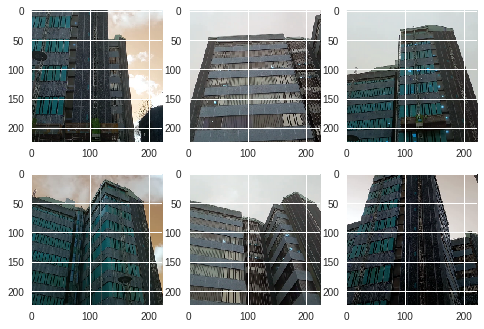

In [95]:
plot_samples("boyd", file_index)

### Adam Smith

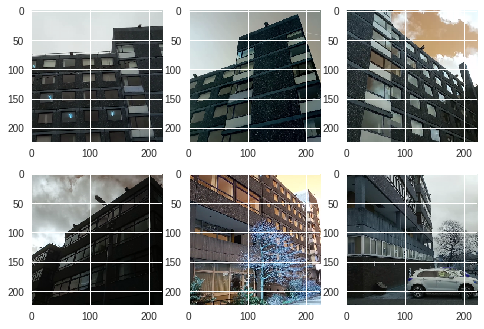

In [96]:
plot_samples("adam", file_index)

### Rankine

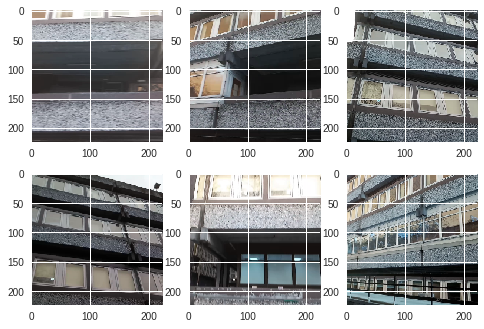

In [97]:
plot_samples("rankine", file_index)

### James watt (South)

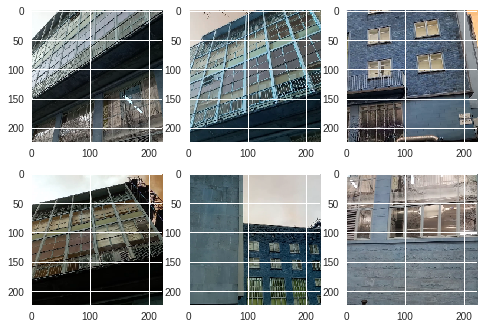

In [98]:
plot_samples("james", file_index)

### Main Building

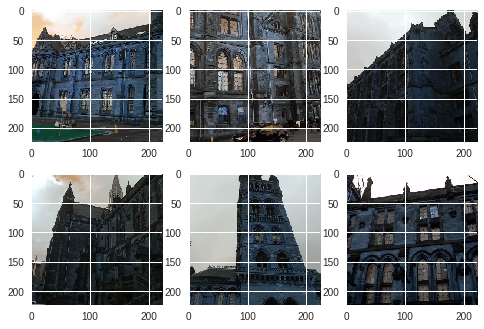

In [99]:
plot_samples("main", file_index)

### Reading Room

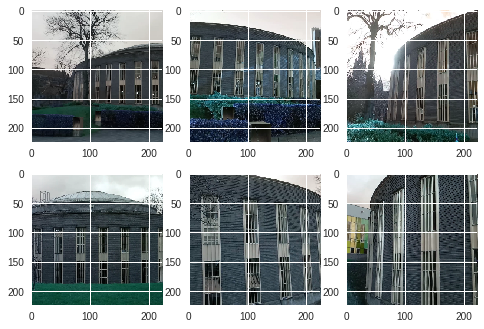

In [100]:
plot_samples("reading", file_index)

## Plotting Distributions Functions

In [0]:
def plot_subplot(file_index, day, axis, max_y):
    counts = {}
    for key, value in file_index[day].items():
        counts[key] = len(value)
        
    axis.bar(range(len(counts)), list(counts.values()), align='center')
    axis.set_title("Day: " + day)
    axis.set_xticks(range(len(counts)))
    axis.set_xticklabels(list(counts.keys()))
    axis.set_ylim(0, max_y)

In [0]:
def plot_day_distribution(index, picture_folders, max_y_val):
    f, axarr = plt.subplots(2, 2)
    plot_subplot(index, picture_folders[0] , axarr[0, 0], max_y_val)
    plot_subplot(index, picture_folders[1] , axarr[0, 1], max_y_val)
    plot_subplot(index, picture_folders[2] , axarr[1, 0], max_y_val)
    plot_subplot(index, picture_folders[3] , axarr[1, 1], max_y_val)

    for ax in axarr.flat:
        ax.set(xlabel='Building', ylabel='Number of Pictures')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axarr.flat:
        ax.label_outer()


In [0]:
max_y_val = 0
for folder in file_index.values():
    for count in folder.values():
        count = len(count)
        if count > max_y_val:
            max_y_val = count
            
max_y_val += 100

### Number of pictures per class (total)

In [0]:
def plot_total_distribution(index):
    type_counts = {
        "boyd": 0,
        "adam": 0,
        "reading": 0,
        "main": 0,
        "james": 0,
        "main": 0,
        "rankine": 0
    }
    
    for folder in index.values():
        for label, count in folder.items():
            type_counts[label] += len(count)
    
    plt.bar(range(len(type_counts)), list(type_counts.values()), align='center')
    plt.title("Total Pictures per Class")
    plt.xticks(range(len(type_counts)), list(type_counts.keys()))

## Distributions of the Dataset

### Figure 1: Picture Distribution per Day per Class

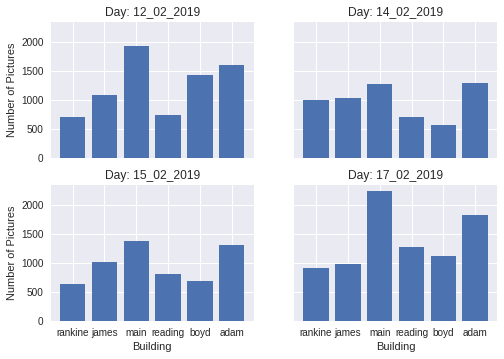

In [15]:
plot_day_distribution(file_index, picture_folders, max_y_val)

### Figure 2: Total Pictures per Class

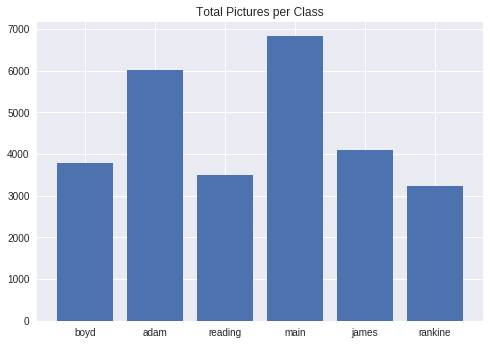

In [17]:
plot_total_distribution(file_index)

Figures 1 and 2 show that there is a clear class imbalance between the buildings. The Adam Smith building and the University Main building have significantly more images (almost double). If the model were to be trained directly on this data then it would likely be biased towards the Adam Smith and Main buildings.

Figure 1 shows that there is a similiar distribution over classes for each day.


## Handling Class Imbalance
To handle the class imbalance we will sub-sample the data.
Although this will result in a large loss of information, because the pictures were taken from videos, two consectuive frames contain almost identical information and so it is hoped by removing frames randomly it will limit the amount of information lost.

The data will be subsampled down to the length of the least represented category for each day.

In [0]:
sub_sampled_index = deepcopy(file_index)

In [0]:
for folder in sub_sampled_index.keys():
    min_count = 0
    first = True
    # find minimum for day
    for label in labels:
        count = len(sub_sampled_index[folder][label])
        if first:
            min_count = count
            first = False
            
        else:
            if count < min_count:
                min_count = count
    for label in labels:
        arr = sub_sampled_index[folder][label]
        sub_sampled_index[folder][label] = np.random.choice(arr, min_count, replace=False)

In [0]:
max_y_val = 0
for folder in sub_sampled_index.values():
    for count in folder.values():
        count = len(count)
        if count > max_y_val:
            max_y_val = count
            
max_y_val += 100

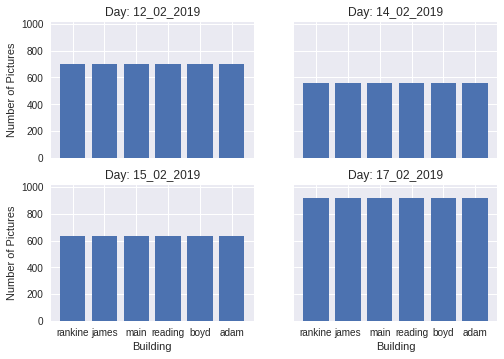

In [21]:
plot_day_distribution(sub_sampled_index, picture_folders, max_y_val)

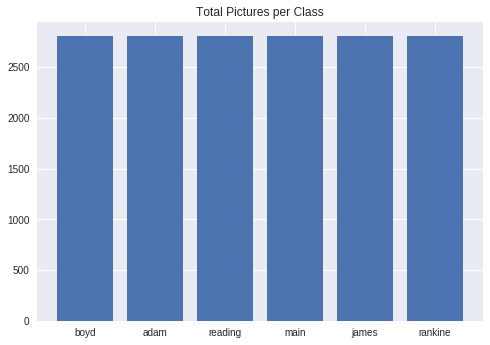

In [22]:
plot_total_distribution(sub_sampled_index)

As the graph shows, after applying the subsampling there is an equal distribution for each class.

In [0]:
SAVE_SUBSAMPLED = False
SUBSAMPLED_PATH = RESULTS_PATH + "subsampled/"
make_path(SUBSAMPLED_PATH)

if SAVE_SUBSAMPLED:
    with open(SUBSAMPLED_PATH + "index.pkl", 'wb') as results_file:
        pickle.dump(sub_sampled_index, results_file)
        
with open(SUBSAMPLED_PATH + "index.pkl", 'rb') as results_file:
    sub_sampled_index = pickle.load(results_file)

# Data Generator Setup

A custom data generator was used for this task as the standard flow form directory can not be used to keep days seperated.

The structure for the generator code was taken from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
. A similiar version had already been implemented for my fourth year project.

---

**Data Augmentation**

To increase the amount of data available to the model, online data augmentation is used.  For each image, one of three augmentations at a random level of intensity is performed.

The three augmentations are:

* Image Zoom
* Brightness
* Rotation

Image zoom was used to try and help the model generalize to images taken closer up to the buildings. A negative zoom was considered but found to distort the image too much.

Brightness augmentation was used to try and simulate pictures taken in the evening (darker) and images that have been over exposed due to bright sunlight.

Rotation was used to simulate the input from a mobile app as it is likely to vary significantly depending on how the user is holding their phone. The rotation was limited to 80 degrees either way as past that the phone's autorotate would likely be activated. It is also unliekly that a user would take an image upsidedown.

Translation was investigated but found to distort the image too much. Furthermore, as the images were exreacted from a video, two consectutive frames simuate the effect of translation.

Mirroring of the image was not implemented as some buildings are not necessarily symetrical.



In [0]:
'''Based on code from 
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
also similiar version used in fourth year project'''

class DataGenerator(Sequence):
    """Generates data for Keras"""
    def __init__(self, list_IDs, labels, batch_size, dim, n_classes,
                 shuffle=False, augment=False):
        """Initialization"""
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment

        self.indexes = None
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def augment_image(self, img):
        mode = np.random.randint(0, 3)
        
        # brightness
        if mode == 0:
            return image.random_brightness(img, (0.5, 1.5))
            
        # rotation
        elif mode == 1:
            return image.random_rotation(img, 80,0,1,2)
        
        # zoom
        elif mode == 2:
            return image.random_zoom(img, (0.5,1.0), 0, 1, 2)

                    

    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = np.empty((self.batch_size, *self.dim))

        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):

            img = image.load_img(ID)
            img = image.img_to_array(img)
            
            if self.augment:
                img = self.augment_image(img)
            
            if len(self.dim) == 1:
                img = img[:,:,1].flatten()
                
            X[i,] = img/255
            # Store class
            y[i] = self.labels[ID]

        return X, to_categorical(y, num_classes=self.n_classes)

In [24]:
# used for converting labels to ints
conversion_table = {}
for index, label in enumerate(labels):
    conversion_table[label] = index

conversion_table

{'adam': 5, 'boyd': 4, 'james': 1, 'main': 2, 'rankine': 0, 'reading': 3}

# Creation of multiple candidate network architectures.

Three initial model archetectures were evaluated:


**Model 1**

The first model is a basic fully connected neural network with four layers.
The first layer uses 256 nodes folled by 128, 64 and finally 6 nodes to match the numer of classes of buildings.

---

**Model 2**

Model 2 is the pretrained ResNet 50 model (trained on imagenet). 

---
**Model 3**

Model 3 is a smaller version of the VGG16 network. Initially no dropout was used.

## Model 1: Three Layer Dense Network

In [0]:
def four_layer_dense(input_shape, output_shape):
    model = Sequential(name="three_layer_dense")
    model.add(Dense(128, input_shape=input_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    return model

## Model 2: ResNet 50

In [0]:
def res50(output_shape, pretrained=False):
    if pretrained:
        base_model = ResNet50(include_top=False, weights="imagenet", pooling="avg")
        
    else:
        base_model = ResNet50(include_top=False, weights="imagenet", pooling="avg")
        
    x = Dense(1024, activation='relu')(base_model.output)
    predictions = Dense(output_shape, activation='softmax')(x)

    model = Model(base_model.input, predictions)
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

## Model 3: Downscaled VGG16 (Simple CNN)

In [0]:
def vgg16(input_shape, use_dropout=False, dropout=0.2):
    model = Sequential(name="test")

    model.add(Convolution2D(64, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(dropout))
        
    model.add(Convolution2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(dropout))

    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_dropout:
        model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    
    return model

# Methods to Aid Visualization

In [0]:
def plot_accuracy(history, title):
    training = np.array(history["acc"])*100
    validation = np.array(history['val_acc' ])*100
    epoch_count = range(1, len(training) + 1)
    plt.plot(epoch_count, training, 'b--')
    plt.plot(epoch_count, validation, 'r-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.show()
    
def plot_loss(history, title):
    training = history["loss"]
    validation = history['val_loss' ]
    epoch_count = range(1, len(training) + 1)
    plt.plot(epoch_count, training, 'b--')
    plt.plot(epoch_count, validation, 'r-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

In [0]:
# Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Training

In [0]:
def compute_confusion_matrix(val_generator, index, predictions):
    predictions = np.argmax(predictions,axis=1)
    true_labels = []
    for img in val_generator.list_IDs:
        true_labels.append(index[img])
        
    true_labels = np.array(true_labels)
    true_labels = true_labels[:len(predictions)]
        
    return confusion_matrix(true_labels, predictions)


In [0]:
def evaluate_model(model, epochs, train, val, complete_index, input_size, batch_size, output_size):
    train_generator = DataGenerator(train, complete_index, batch_size,
                                    input_size, output_size, shuffle=True,
                                    augment=True)
    val_generator = DataGenerator(val, complete_index, batch_size,
                                  input_size, output_size, shuffle=False,
                                  augment=False)
    
    history = model.fit_generator(generator=train_generator,
                                  validation_data=val_generator,
                                  use_multiprocessing=True,
                                  workers=multiprocessing.cpu_count(),
                                  epochs=epochs,
                                  verbose=1)
    
    predictions = model.predict_generator(val_generator,
                                    workers=multiprocessing.cpu_count(),
                                    use_multiprocessing=True, verbose=1)
    
    conf_matrix = compute_confusion_matrix(val_generator, complete_index, predictions)
    return {
        "confusion_matrix": conf_matrix,
        "history": history.history
    }

## Initial Model Comparison
As the data was generated from a video, concurrent frames are very similiar. Therefore, if the test set is randomly selected then it is very likely the model will be trained on almost identical images giving misleading results.

To solve this the data collected on the 14/02/2019 will be used exclusivly for final evaluation of the model as it contains the least number of photos after the sub-sampling process. 

For training the models the remaining data will be used. For validation, 3-fold cross-validation will be used with each fold representing a full day of data.

Train | Test
--|--
12/02/2019 | 14/02/2019
15/02/2019|
17/02/2019|

---

**Data Augmentation**

*TODO, talk about why zoom, brightness and rotation*

In [0]:
# Used to prevent overwriting of results
RUN_MODEL_1 = False
SAVE_RESULTS_MODEL_1 = False

RUN_MODEL_2 = False
SAVE_RESULTS_MODEL_2 = False

RUN_MODEL_3 = False
SAVE_RESULTS_MODEL_3 = False

RUN_MODEL_3_dropout = True
SAVE_RESULTS_MODEL_3_dropout = True

In [0]:
epochs = 10
batch_size = 64

In [0]:
# Create folder to save results
RESULTS_PATH = BASE_PATH + 'results/'
make_path(RESULTS_PATH)
RESULTS_PATH_INITIAL = RESULTS_PATH + 'initial_investigation/'
make_path(RESULTS_PATH_INITIAL)

In [0]:
data = deepcopy(sub_sampled_index)
#Remove test day as used for final evalaution
del data["14_02_2019"]

In [0]:
complete_index = {}
partition = {'train':[], 'validation':[]} # contains list of training and validation ID's
validation_day = "15_02_2019" # use this day for validation

for day, buildings in data.items():
    for building, images in buildings.items():
        for img in images:
            if day == validation_day:
                partition["validation"].append(img)
                complete_index[img] = conversion_table[building]

            else:
                partition["train"].append(img)
                complete_index[img] = conversion_table[building]

In [0]:
confusion_labels = []
for i in range(7):
    for building, value in conversion_table.items():
        if i == value:
            confusion_labels.append(building)

### Model 1 (Four Layer Dense)

In [0]:
input_shape = TARGET_IMAGE_SHAPE[0] ** 2 # only use grayscale to reduce training time

In [41]:
model = four_layer_dense((input_shape,), len(labels))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_1:
    results = evaluate_model(model, epochs,
                             partition["train"], partition["validation"],
                             complete_index, (input_shape,),
                             batch_size, len(labels))

Epoch 1/10
151/151 [==============================] - 1936s 13s/step - loss: 4.1399 - acc: 0.2168 - val_loss: 1.9644 - val_acc: 0.2246
Epoch 2/10
151/151 [==============================] - 116s 769ms/step - loss: 1.8364 - acc: 0.2569 - val_loss: 1.7801 - val_acc: 0.2783
Epoch 3/10
151/151 [==============================] - 114s 758ms/step - loss: 1.7782 - acc: 0.2843 - val_loss: 1.8237 - val_acc: 0.2852
Epoch 4/10
151/151 [==============================] - 115s 761ms/step - loss: 1.6884 - acc: 0.3119 - val_loss: 1.8651 - val_acc: 0.3120
Epoch 5/10
151/151 [==============================] - 114s 754ms/step - loss: 1.6797 - acc: 0.3220 - val_loss: 1.7647 - val_acc: 0.3038
Epoch 6/10
151/151 [==============================] - 116s 767ms/step - loss: 1.6573 - acc: 0.3282 - val_loss: 1.7160 - val_acc: 0.3167
Epoch 7/10
151/151 [==============================] - 115s 761ms/step - loss: 1.6266 - acc: 0.3385 - val_loss: 1.7404 - val_acc: 0.2709
Epoch 8/10
151/151 [=============================

In [0]:
if SAVE_RESULTS_MODEL_1:
    with open(RESULTS_PATH_INITIAL + "model_1.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Model 2 (ResNet50)

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

#### Using pretrained weights
It was found that freezing the the bottom layers does not work (gives very high training accuracy but as good as random validation accuracy). This is due to the batchnormalization layers and is discussed in 
[Keras Issue 9214](https://github.com/keras-team/keras/issues/9214).
To overcome this, all batch normalization layers have been unfrozen according to [Stackoverflow high acc, low val-acc ](https://stackoverflow.com/questions/53134404/keras-transfer-learning-resnet50-using-fit-generator-got-high-acc-but-low-val-ac).

In [74]:
# returned model has all base layers frozen
model = res50(len(labels), pretrained=True)

# unfreeze batch normalization layers
for layer in model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        
# unfreeze top two blocks of ResNet
for layer in model.layers[155:]:
        layer.trainable = True
        
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#train top layers for several epochs
if RUN_MODEL_2:
    results = evaluate_model(model, epochs,
                               partition["train"], partition["validation"],
                               complete_index, input_shape,
                               batch_size, len(labels))

Epoch 1/10
151/151 [==============================] - 252s 2s/step - loss: 0.0593 - acc: 0.9808 - val_loss: 0.2266 - val_acc: 0.9656
Epoch 2/10
151/151 [==============================] - 230s 2s/step - loss: 0.0208 - acc: 0.9958 - val_loss: 0.0785 - val_acc: 0.9770
Epoch 3/10
151/151 [==============================] - 229s 2s/step - loss: 0.0056 - acc: 0.9984 - val_loss: 0.0235 - val_acc: 0.9921
Epoch 4/10
151/151 [==============================] - 230s 2s/step - loss: 0.0056 - acc: 0.9983 - val_loss: 0.0608 - val_acc: 0.9857
Epoch 5/10
151/151 [==============================] - 230s 2s/step - loss: 6.3170e-04 - acc: 0.9999 - val_loss: 0.0133 - val_acc: 0.9963
Epoch 6/10
151/151 [==============================] - 230s 2s/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.0237 - val_acc: 0.9923
Epoch 7/10
151/151 [==============================] - 232s 2s/step - loss: 0.0076 - acc: 0.9983 - val_loss: 2.2612 - val_acc: 0.8403
Epoch 8/10
151/151 [==============================] - 230s 2s/ste

In [0]:
if SAVE_RESULTS_MODEL_2:
    with open(RESULTS_PATH_INITIAL + "model_2.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Model 3 (Downscaled VGG16)

#### No Dropout

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [39]:
model = vgg16(input_shape, use_dropout=False)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_3:
    results = evaluate_model(model, epochs, partition["train"], partition["validation"],
                             complete_index, input_shape, batch_size, len(labels))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
151/151 [==============================] - 1291s 9s/step - loss: 1.8042 - acc: 0.2391 - val_loss: 1.6320 - val_acc: 0.3112
Epoch 2/10
151/151 [==============================] - 237s 2s/step - loss: 1.3097 - acc: 0.4825 - val_loss: 1.3444 - val_acc: 0.4632
Epoch 3/10
151/151 [==============================] - 235s 2s/step - loss: 0.8068 - acc: 0.6966 - val_loss: 1.2797 - val_acc: 0.5898
Epoch 4/10
151/151 [==============================] - 236s 2s/step - loss: 0.5091 - acc: 0.8168 - val_loss: 1.5210 - val_acc: 0.6184
Epoch 5/10
151/151 [==============================] - 235s 2s/step - loss: 0.3536 - acc: 0.8778 - val_loss: 1.7071 - val_acc: 0.6600
Epoch 6/10
151/151 [==============================] - 236s 2s/step - loss: 0.2492 - acc: 0.9170 - val_loss: 1.9444 - val_acc: 0.6772
Epoch 7/10
151/151 [==============================] - 234s 2s/step - loss: 0.1830

In [0]:
if SAVE_RESULTS_MODEL_3:
    with open(RESULTS_PATH_INITIAL + "model_3.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

#### Dropout: 0.2
Increased epochs 

In [0]:
input_shape = (TARGET_IMAGE_SHAPE[0], TARGET_IMAGE_SHAPE[1], 3)

In [40]:
model = vgg16(input_shape, use_dropout=True, dropout=0.2)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

if RUN_MODEL_3_dropout:
    results = evaluate_model(model, epochs+5, partition["train"], partition["validation"],
                             complete_index, input_shape, batch_size, len(labels))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
151/151 [==============================] - 722s 5s/step - loss: 1.7677 - acc: 0.2667 - val_loss: 1.5950 - val_acc: 0.3557
Epoch 2/15
151/151 [==============================] - 245s 2s/step - loss: 1.1512 - acc: 0.5476 - val_loss: 1.7165 - val_acc: 0.4290
Epoch 3/15
151/151 [==============================] - 244s 2s/step - loss: 0.9013 - acc: 0.6542 - val_loss: 1.2986 - val_acc: 0.5853
Epoch 4/15
151/151 [==============================] - 246s 2s/step - loss: 0.6457 - acc: 0.7633 - val_loss: 1.5083 - val_acc: 0.5874
Epoch 5/15
151/151 [==============================] - 246s 2s/step - loss: 0.4975 - acc: 0.8211 - val_loss: 1.8400 - val_acc: 0.6367
Epoch 6/15
151/151 [==============================] - 250s 2s/step - loss: 0.3456 - acc: 0.8812 - va

In [0]:
if SAVE_RESULTS_MODEL_3_dropout:
    with open(RESULTS_PATH_INITIAL + "model_3_dropout.pkl", 'wb') as results_file:
        pickle.dump(results, results_file)

### Comparison of Results

In [0]:
with open(RESULTS_PATH_INITIAL + "model_1.pkl", 'rb') as results_file:
    model_1_results = pickle.load(results_file)
    
with open(RESULTS_PATH_INITIAL + "model_2.pkl", 'rb') as results_file:
    model_2_results = pickle.load(results_file)
    
with open(RESULTS_PATH_INITIAL + "model_3.pkl", 'rb') as results_file:
    model_3_results = pickle.load(results_file)

#### Comparison of Validation Accuracy

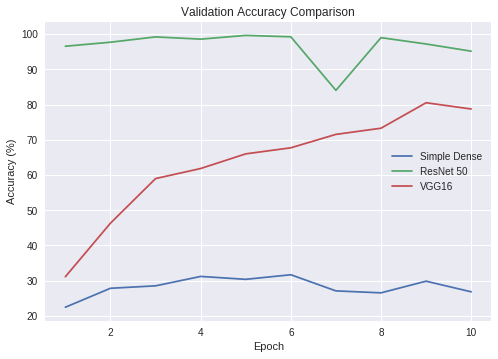

In [45]:
model_1 = np.array(model_1_results["history"]["val_acc"]) * 100
model_2 = np.array(model_2_results["history"]["val_acc"]) * 100
model_3 = np.array(model_3_results["history"]["val_acc"]) * 100
epoch_count = range(1, epochs + 1)
plt.plot(epoch_count, model_1, label="Simple Dense")
plt.plot(epoch_count, model_2, label="ResNet 50")
plt.plot(epoch_count, model_3, label="VGG16")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Comparison")
plt.show()

#### Confusion Matricies

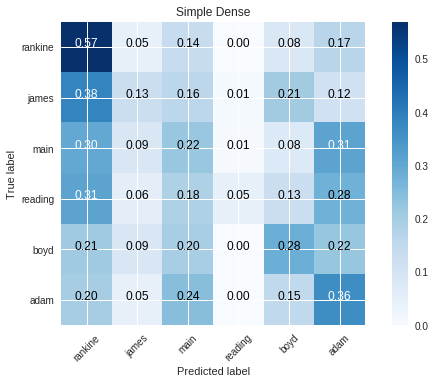

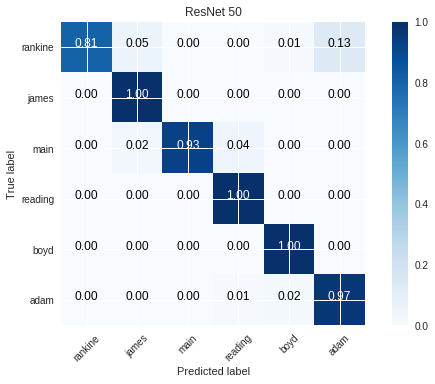

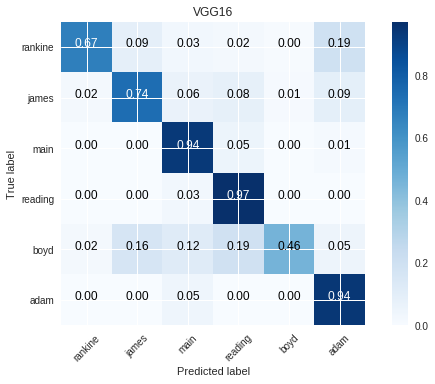

In [53]:
plot_confusion_matrix(model_1_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='Simple Dense')

plot_confusion_matrix(model_2_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='ResNet 50')

plot_confusion_matrix(model_3_results["confusion_matrix"], confusion_labels,
                      normalize=True, title='VGG16')

#### Training vs Validation Accuracy Analysis

In [0]:
plot_accuracy(model_1_results["histroy"], "Simple Dense")
plot_accuracy(model_2_results["histroy"], "ResNet 50")
plot_accuracy(model_3_results["histroy"], "VGG16")

#### Training vs Validation Loss Analysis

In [0]:
plot_loss(model_1_results["histroy"], "Simple Dense")
plot_loss(model_2_results["histroy"], "ResNet 50")
plot_loss(model_3_results["histroy"], "VGG16")

## Regularization

## Hyperparameter Tuning

Based on the results from the initial model comparison, model __ has been selected for further tuning. For the metric to minimise, the average validation loss based on three fold cross-validation (one fold for each day).

In [0]:
def evaluate_model_v2(model, epochs, train, val, complete_index, input_size,
                      batch_size, output_size,
                      use_early_stopping=False, early_stopping_patience=0):
    
    train_generator = DataGenerator(train, complete_index, batch_size,
                                    input_size, output_size, shuffle=True,
                                    augment=True)
    val_generator = DataGenerator(val, complete_index, batch_size,
                                  input_size, output_size, shuffle=False,
                                  augment=False)
    
    model.fit_generator(generator=train_generator,
                      validation_data=val_generator,
                      use_multiprocessing=True,
                      workers=multiprocessing.cpu_count(),
                      epochs=epochs,
                      verbose=0)
    
    return model.evaluate_generator(generator=val_generator,
                                    use_multiprocessing=True,
                                    workers=multiprocessing.cpu_count(),
                                    verbose=1)

In [0]:
def split_data_by_day(data, validation_day):
    complete_index = {}
    partition = {'train':[], 'validation':[]} # contains list of training and validation ID's

    for day, buildings in data.items():
        for building, images in buildings.items():
            for img in images:
                if day == validation_day:
                    partition["validation"].append(img)
                    complete_index[img] = conversion_table[building]

                else:
                    partition["train"].append(img)
                    complete_index[img] = conversion_table[building]
                    
    return {"complete_index": complete_index,
            "validation":partition["validation"],
            "train":[partition["train"]]}

In [0]:
data = deepcopy(sub_sampled_index)
#Remove test day as used for final evalaution
del data["14_02_2019"]

In [0]:
space = [
    Categorical(['adam', 'sgd_standard', 'sgd_nestrov'], name='optimizer'),
    Real(0.0001, 0.1, "log-uniform", name='learning_rate'),
    Categorical(['relu', 'sigmoid', 'tanh'], name='activation'),
    Real(0.1, 0.9, name='dropout'),
    Integer(16, 1024, name='num_dense_nodes'),
    Integer(1,3, name='num_dense_layers'),
    Integer(2,5, name='kernel_size'),
    Integer(2,4, name='pooling_size'),
    Integer(8, 1024, name='batch_size')
]

In [0]:
@use_named_args(space)
def objective(**params):
    average_loss = 0
    for day in data.keys():
        data_split = split_data_by_day(data, day)
        #Make Model#

        if params['optimizer'] == 'adam':
            selected_optimizer = Adam(lr=params['learning_rate'])
            
        elif params['optimizer'] == 'sgd_standard':
            selected_optimizer = SGD(lr=params['learning_rate'])
            
        else:
            #nestrov momentum
            selected_optimizer = SGD(lr=params['learning_rate'], decay=1e-6, 
                                     momentum=0.9, nesterov=True)
            
        model.compile(loss='categorical_crossentropy',
                      optimizer=selected_optimizer,
                      metrics=['accuracy'])

        evaluation = evaluate_model(model, epochs,
                         partition["train"], partition["validation"],
                         complete_index, (input_shape,),
                         batch_size, len(labels))
        
        print(evaluation)

        average_loss += evaluation[0]
        
    return average_loss/len(users) # minimize avg val_loss

In [0]:
checkpoint = CheckpointSaver(RESULTS_PATH + "res_gp_checkpoint.pkl")
callbacks_list = [checkpoint]

In [0]:
LOAD_CHECKPOINT = True

In [0]:
if LOAD_CHECKPOINT:
    res = load(RESULTS_PATH + "res_gp_checkpoint.pkl")
    x0 = res.x_iters
    y0 = res.func_vals
    
else:
    x0 = None
    y0 = None

In [0]:
res_gp = gp_minimize(objective, space, x0=x0, y0=y0,
                     n_calls=122, n_random_starts=10,
                     random_state=0, callback=callbacks_list)

In [0]:
dump(res_gp, RESULTS_PATH + "res_gp_complete.pkl")

In [0]:
res_gp = load(RESULTS_PATH + "res_gp_complete.pkl")

In [0]:
plt.scatter(range(1, n_calls + 1), -(np.array(res_gp.func_vals)*100), marker='x')
plt.scatter([np.argmin(res_gp.func_vals)+1],[-res_gp.fun*100],
            marker='x', color='red',
            label="Best Accuracy: " + str(round(-res_gp.fun*100, 2))+"%")
plt.legend(bbox_to_anchor=(0.5,0.35), loc="upper left")
plt.ylabel("Classification Accuracy (%)")
plt.xlabel("Number of Calls")
plt.grid()
plt.title("Hyperparameter Search")
plt.savefig(RESULTS_PATH + "hyperparameter_search.pdf", format='pdf')

# Evaluation

## Train on days _ _ _ and evalaute on _

## Train on 80% from all days and test on remaining 20%

## Four fold cross-validation (one fold for each day)

# Fully Trained Model (For Deployment)

# Conclusion 

In [0]:
#@title Load the Flowers data set and split into test & train sets [RUN ME]
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)
  
download_images()

!rm ./flower_photos/LICENSE.txt
if not os.path.exists('./flowers'):
    os.mkdir('./flowers')


image_dir = FLOWERS_DIR
from sklearn.model_selection import train_test_split

# Read all flower images (.jpg) from a folder
# The function returns both the path of the flower image and the corresponding label
# which is defined by the name of the foler in which the image is
def read_images_from_dir(base_dir, folder):
    path_folder = os.path.join(image_dir, folder)
    files_directory = os.listdir(path_folder)
    
    labels = []
    images = []
    for file in files_directory:
        if file.endswith('.jpg'):
            labels.append(folder)
            images.append(os.path.join(path_folder, file))
    return labels, images

def read_images(base_dir):
    labels = []
    images = []
    folders = os.listdir(image_dir)
    for folder in folders:
        labels_folder, images_folder = read_images_from_dir(base_dir, folder)
        labels.extend(labels_folder)
        images.extend(images_folder)
    return labels, images

labels, images = read_images(image_dir)


# Split the data into test and training sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)

# Create folders for test and training that can be passed to Keras Generators
train_folder = './flowers/output/train'
test_folder  = './flowers/output/test'
output_folder = './flowers/output'

def create_output_folders():
    if not os.path.exists(output_folder):
        print('Creating output directories')
        os.mkdir(output_folder)
        if not os.path.exists(train_folder):
            os.mkdir(train_folder)
            for label in set(labels):
                os.mkdir(train_folder + '/' + label)
        if not os.path.exists(test_folder):
            os.mkdir(test_folder)
            for label in set(labels):
                os.mkdir(test_folder + '/' + label)

def copy_files_to_train_and_validation_folders():            
    print('Copy training files to directory')
    for index, value in enumerate(images_train):
        dest = os.path.join(train_folder, labels_train[index])
        shutil.copy(value, dest)

    print('Copy test files to directory')        
    for index, value in enumerate(images_test):
        shutil.copy(value, test_folder + '/' + labels_test[index])
        
create_output_folders()
copy_files_to_train_and_validation_folders()

We now create some data generators for working with the flowers data

In [0]:
#images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=8, stratify=labels)

image_size = 224
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator      = data_generator.flow_from_directory(train_folder, target_size=(image_size, image_size), batch_size=24, class_mode='categorical')
validation_generator = data_generator.flow_from_directory(test_folder, target_size=(image_size, image_size), batch_size=24, class_mode='categorical')

Adapt the code below to work with the generators, then proceed with the experiments!



*   construction work
*   weather conditions such as fog and snow
*   full perimeter often unavailable due to construction
*   lack of variation in distance (not any images from far away)
*   only one camera used
*   variations in lighting only simualted, no evening images

